In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt
from bayestools_open import BayesTools
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format='retina'

matplotlib.rcParams['font.size'] = 16

In [26]:
# create mock data
hosts = [random.gauss(12., 0.5) for i in range(10000)]
mockvmax = np.array([random.gauss(86., 17.) for i in range(10000)])
mockpos = np.array([random.gauss(148., 76.) for i in range(10000)])
mockvel = np.array([random.gauss(148., 90.) for i in range(10000)])

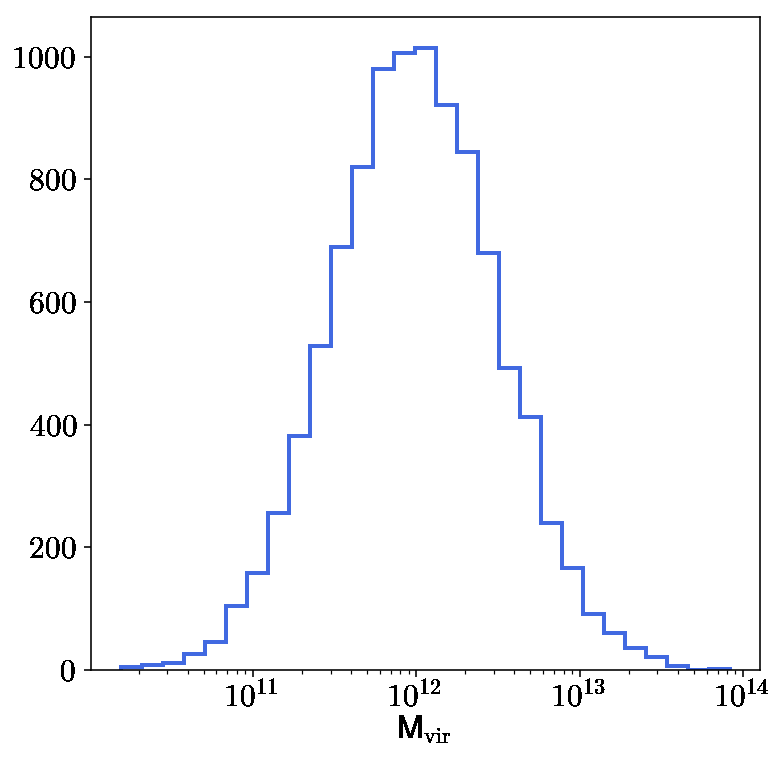

In [27]:
#plot the prior masses
plt.figure(figsize=(6,6))
plt.hist([10.**h for h in hosts], bins=10**np.linspace(np.min(hosts), np.max(hosts), 30), histtype='step', lw=2)
plt.xlabel(r'M$\rm_{vir}$')
plt.xscale('log')

In [28]:
# define data and measurement errors for satellite v_max, r, v_tot, and j                                                                                                                                                                                   
massivesatdata = [75., 10., 150., 15., 150., 22.5, 20000., 3600.]

In [29]:
# BayesTools takes in linear masses in units of 10^10 Msun                                                                                                                                                                                           
linhosts = np.array([10.**h/1e10 for h in hosts])

In [30]:
# create instance of massive satellite                                                                                                                                                                                                                       
sat = BayesTools(linhosts, massivesatdata)

10.0 14.0


In [31]:
# calculate importance sampling weights                                                                                                                                                                                                              
priorweights = np.zeros(len(hosts))

# for massive satellite analogs, use likelihoods including vmax
vmaxweights = sat.vmax_lnweights(mockvmax)
vmaxpvweights = sat.vmaxposvel_lnweights(mockvmax, mockpos, mockvel)

# for low mass satellite analogs, avoid likelihoods including vmax (or you run into the Too Big To Fail problem)
lowmassdata = [15., 10., 60., 15., 140., 20, 14000., 2800.]
lowsat = BayesTools(linhosts, lowmassdata)
posweights = lowsat.pos_lnweights(mockpos)


10.0 14.0


In [32]:
# specify grid over which KDE estimates are approximated                                                                                                                                                                                             
M = np.arange(int(np.min(hosts)), int(np.max(hosts))+1, 0.001)

In [33]:
# calculate probabilities by applying KDE  
priorprobs = sat.kde_gauss(priorweights)

#massive satellite analog
vmaxprobs = sat.kde_gauss(vmaxweights)
vmaxpvprobs = sat.kde_gauss(vmaxpvweights)

#low mass satellite analog
posprobs = lowsat.kde_gauss(posweights)

In [34]:
# calculate summary statistics                                                                                                                                                                                                                       
vmaxmean = sat.weight_mean(vmaxweights)
vmaxlo, vmaxhi = sat.bayes_confint(vmaxprobs, vmaxmean, 0.68)
print 'log10 posterior mean using vmax:', vmaxmean
print 'log10 68% credible interval lengths (lower, upper):', vmaxlo, vmaxhi 


posmean = lowsat.weight_mean(posweights)
poslo, poshi = lowsat.bayes_confint(posprobs, posmean, 0.68)
print 'log10 posterior mean using position:', posmean
print 'log10 68% credible interval lengths (lower, upper):', poslo, poshi

log10 posterior mean using vmax: 11.9903474417
log10 68% credible interval lengths (lower, upper): 0.527063264093 0.496412465169
log10 posterior mean using position: 11.9954145673
log10 68% credible interval lengths (lower, upper): 0.525571030409 0.472113124821


(10.0, 14.0)

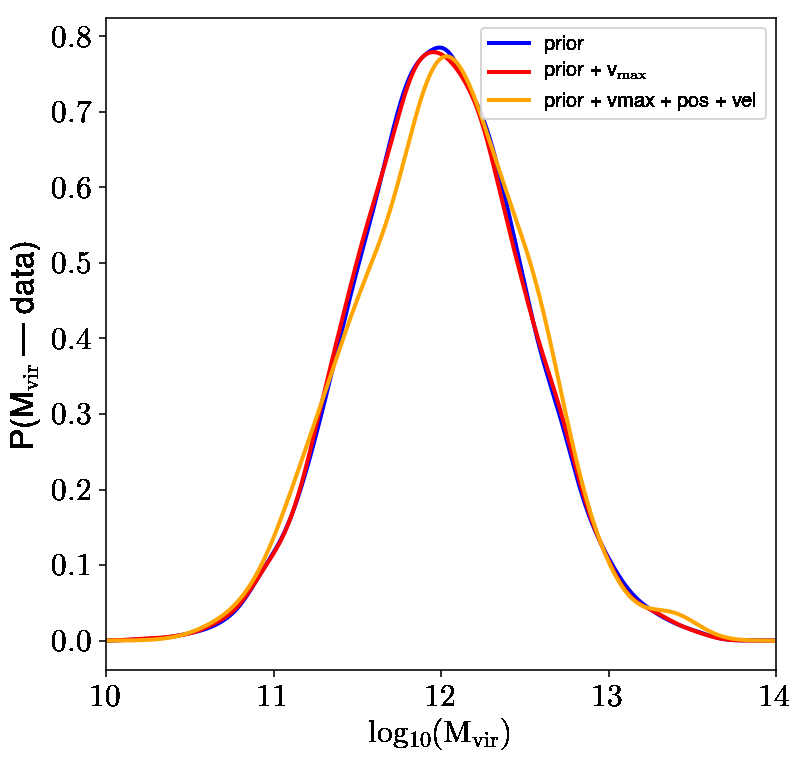

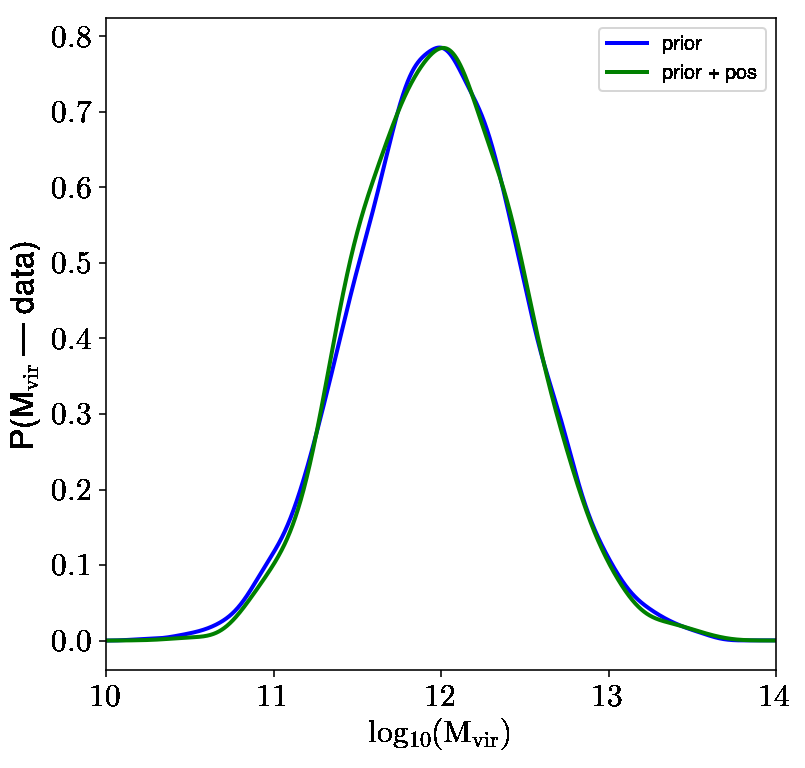

In [37]:
# plot posterior PDFs

#massive satellite
plt.figure(figsize=(6,6))
plt.plot(M, priorprobs, color='blue', lw=2, label='prior')
plt.plot(M, vmaxprobs, color='red', lw=2, label=r'prior + v$\rm_{max}$')
plt.plot(M, vmaxpvprobs, color='orange', lw=2, label=r'prior + vmax + pos + vel')
plt.xlabel(r'$\rm log_{10}(M\rm_{vir})$')
plt.ylabel(r'P(M$\rm_{vir}$ | data)')
plt.legend(loc='upper right',fontsize=10)
plt.xlim(10., 14.)

#low mass satellite 
plt.figure(figsize=(6,6))
plt.plot(M, priorprobs, color='blue', lw=2, label='prior')
plt.plot(M, posprobs, color='green', lw=2, label=r'prior + pos')
plt.xlabel(r'$\rm log_{10}(M\rm_{vir})$')
plt.ylabel(r'P(M$\rm_{vir}$ | data)')
plt.legend(loc='upper right',fontsize=10)
plt.xlim(10., 14.)

In a similar fashion, posterior probabilities can be computed for any physical satellite parameter (i.e. velocity relative to host, angular momentum, etc.) for which simulated data is available. Joint likelihoods are simply the individual likelihood functions summed together in log space. See the script 'bayestools_open.py' for a complete set of likelihood functions used in the publication.

To combine posterior probability distributions for low mass satellites, see Section 3 of Patel, Besla, Mandel, & Sohn  (2018), submittied to ApJ.